In [9]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

In [11]:
import pandas as pd
import numpy as np
import nasdaqdatalink
import cpi
from datetime import date

nasdaqdatalink.ApiConfig.api_key = "exxagMGCnJyiSb49B-1v"

In [12]:
df = (
    nasdaqdatalink.get(dataset="WGC/GOLD_MONAVG_USD", 
                       start_date="2000-01-01", 
                       end_date="2010-12-31")
    .rename(columns={"Value": "price"})
    .resample("M")
    .last()
)

df.head()

,price
Date,
2000-01-31,284.31
2000-02-29,299.86
2000-03-31,286.39
2000-04-30,279.69
2000-05-31,275.19


In [13]:
DEFL_DATE = date(2010, 12, 31)

df["dt_index"] = pd.to_datetime(df.index)
df["price_deflated"] = df.apply(
    lambda x: cpi.inflate(x["price"], x["dt_index"], DEFL_DATE), 
    axis=1
)

df

,price,dt_index,price_deflated
Date,,,
2000-01-31,284.31,2000-01-31,369.163397
2000-02-29,299.86,2000-02-29,387.061337
2000-03-31,286.39,2000-03-31,366.651132
2000-04-30,279.69,2000-04-30,357.864416
2000-05-31,275.19,2000-05-31,351.696029
...,...,...,...
2010-08-31,1215.81,2010-08-31,1220.638444
2010-09-30,1270.98,2010-09-30,1275.285665
2010-10-31,1342.02,2010-10-31,1344.891668


Now please work on the deflated gold price series:
<br>
1. Test the stationary of it;
<br>
2. If it is not stationary, convert it to a stationary series.


Augmented Dickey-Fuller Test: Gold Price Deflated
ADF test statistic        2.195495
p-value                   0.998879
# lags used               0.000000
# observations          131.000000
critical value (1%)      -3.481282
critical value (5%)      -2.883868
critical value (10%)     -2.578677

Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary

Augmented Dickey-Fuller Test: Differenced Gold Price Deflated
ADF test statistic     -1.017191e+01
p-value                 7.053503e-18
# lags used             0.000000e+00
# observations          1.300000e+02
critical value (1%)    -3.481682e+00
critical value (5%)    -2.884042e+00
critical value (10%)   -2.578770e+00

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


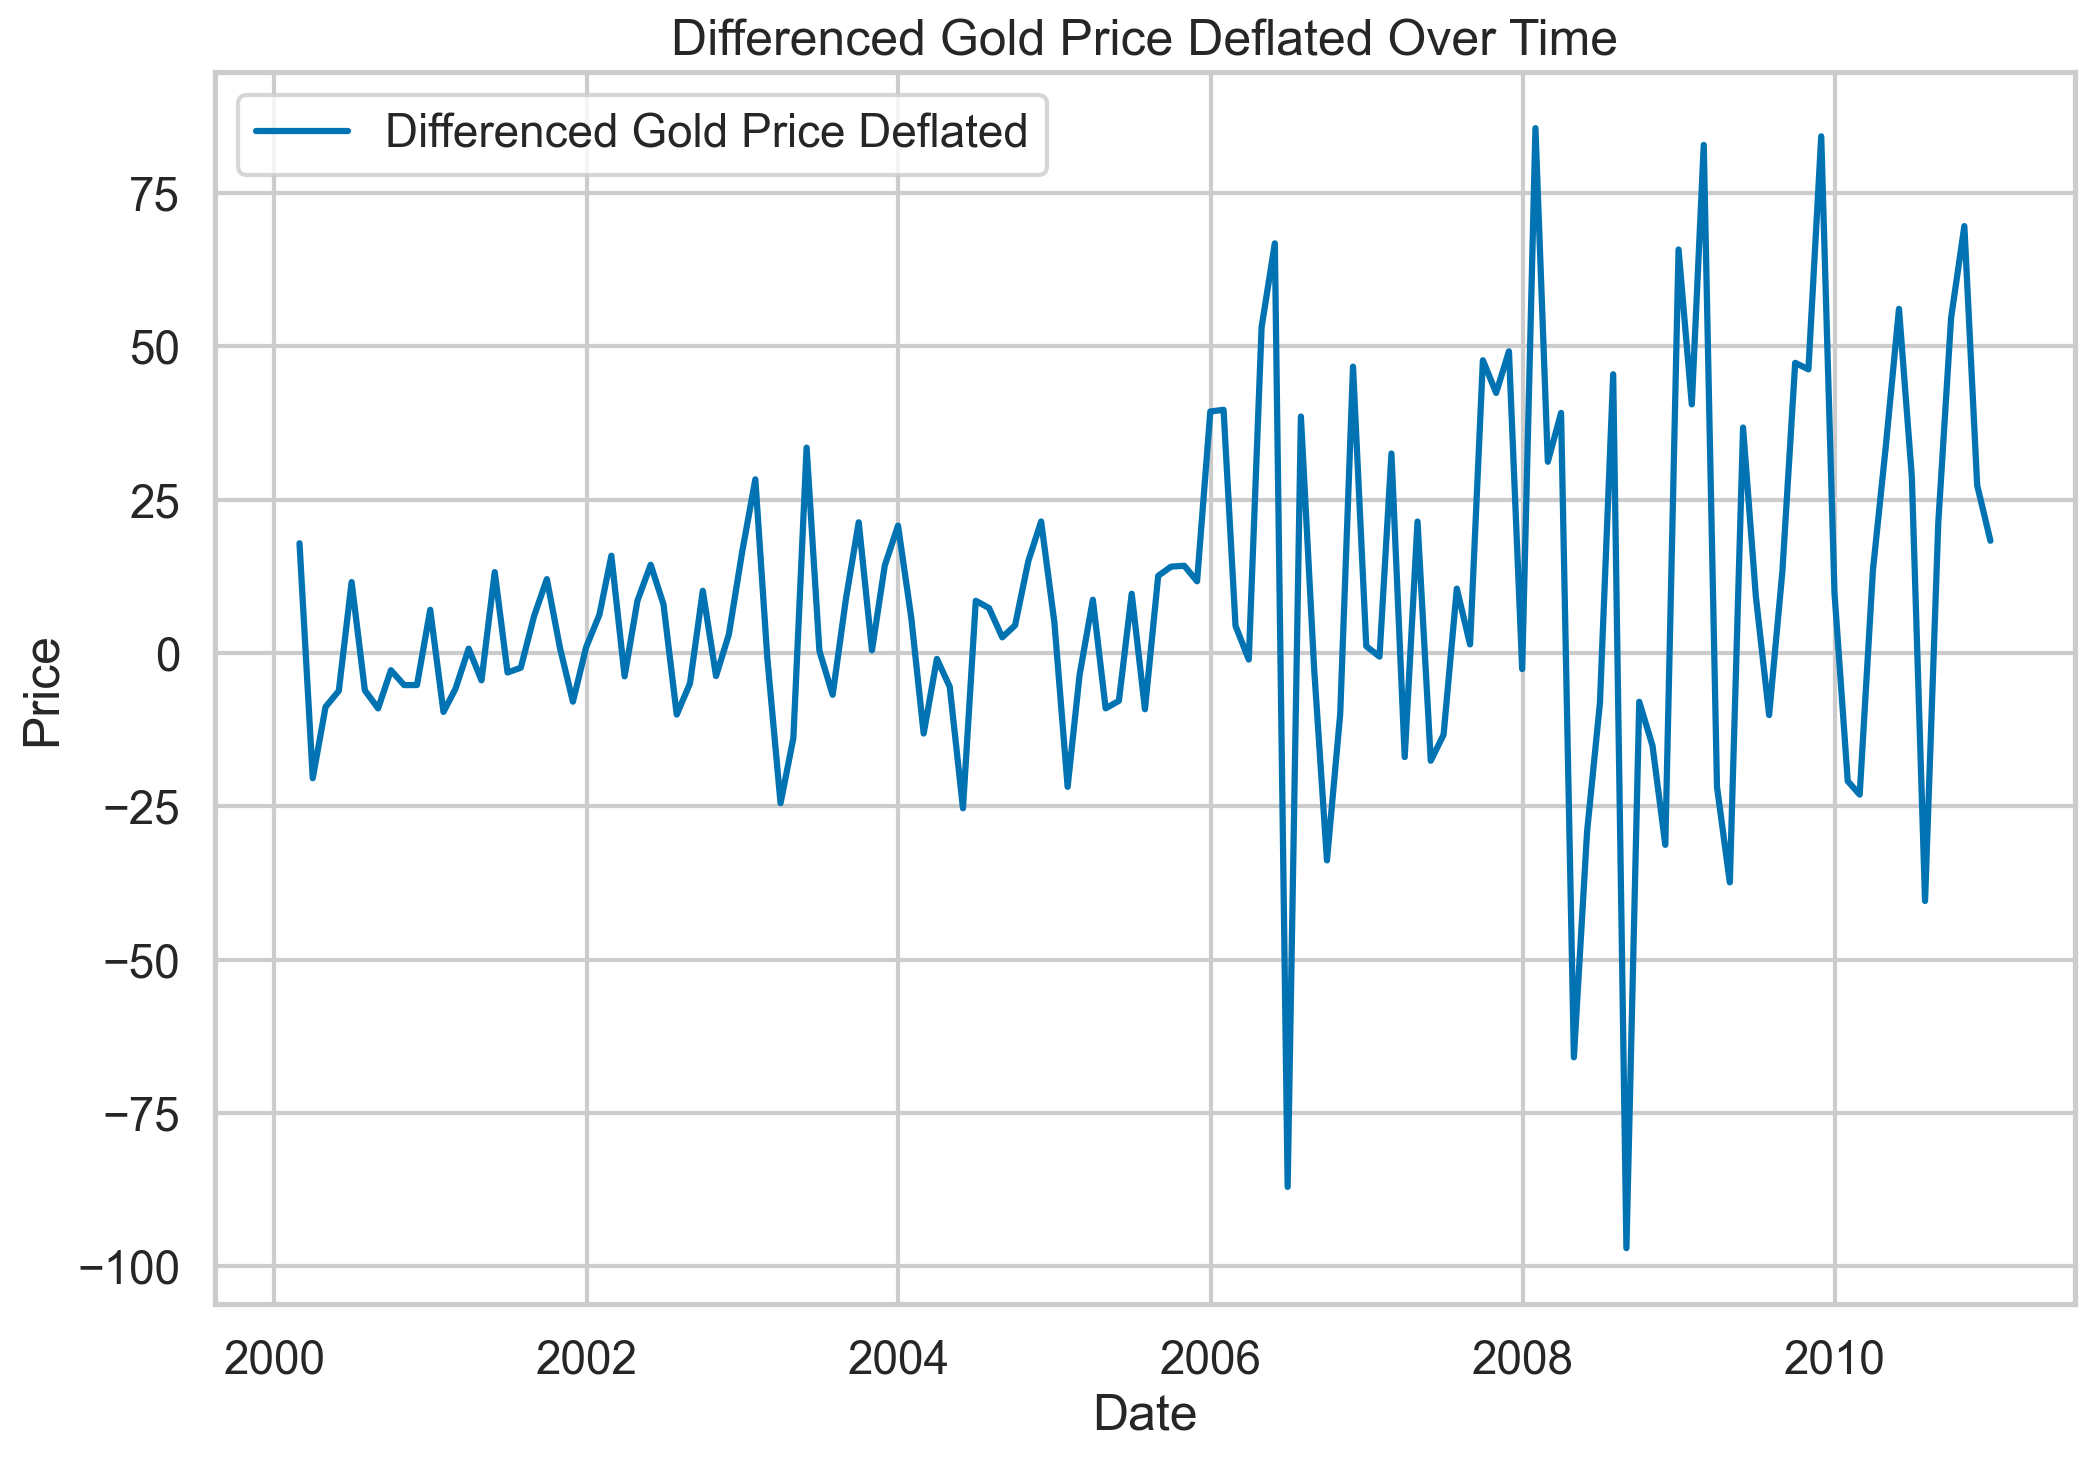

In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Define a function to perform the Augmented Dickey-Fuller test and print the results
def adf_test(series, title=''):
    """
    Perform the Augmented Dickey-Fuller test on a time series and print the results.
    
    Parameters:
        series (pd.Series): The time series data to be tested.
        title (str): An optional title for the test.
    """
    # Perform the ADF test on the series, dropping any NaN values, with automatic lag selection based on AIC criterion
    result = adfuller(series.dropna(), autolag='AIC')
    
    # Define labels for the ADF test results
    labels = ['ADF test statistic', 'p-value', '# lags used', '# observations']
    
    # Create a pandas Series containing the ADF test results
    out = pd.Series(result[0:4], index=labels)

    # Extract critical values from the ADF test results and add them to the output Series
    for key, val in result[4].items():
        out[f'critical value ({key})'] = val
    
    # Print the ADF test results
    print(f'\nAugmented Dickey-Fuller Test: {title}')
    print(out.to_string())

    # Check the p-value to determine whether to reject the null hypothesis of non-stationarity
    if result[1] <= 0.05:
        print("\nStrong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("\nWeak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

# Apply Augmented Dickey-Fuller test to check for stationarity
adf_test(df['price_deflated'], title='Gold Price Deflated')

# If the data is non-stationary, difference the series and re-test for stationarity
if adfuller(df['price_deflated'].dropna())[1] > 0.05:
    # Difference the series
    df['price_deflated_diff'] = df['price_deflated'].diff()
    # Apply ADF test to the differenced series
    adf_test(df['price_deflated_diff'], title='Differenced Gold Price Deflated')
    # Plot the differenced series
    plt.plot(df['price_deflated_diff'], label='Differenced Gold Price Deflated', color='b')
    plt.title('Differenced Gold Price Deflated Over Time')
else:
    # Plot the original series if it is stationary
    plt.plot(df['price_deflated'], label='Gold Price Deflated', color='g')
    plt.title('Gold Price Deflated Over Time')

# Add labels and legend to the plot
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()